In [1]:
## PLOT OPTIMIZATION RESULTS
from plugins.environments.awa_environment import AWAEnvironment
from plugins.interfaces.awa_interface import AWAInterface

# import data from csv file
import pandas as pd
variable_file = "../../plugins/environments/awa_variables.csv"
observable_file = "../../plugins/environments/awa_observables.csv"

env = AWAEnvironment(variable_file, observable_file, interface=AWAInterface(), target_charge=1.0)

In [2]:
from xopt.vocs import VOCS
import yaml
folder = "../../run_data/2023_06_19/"
f_names = [
    #"optimization_nn_2.yml", 
    #"optimization_nn_1.yml", 
    #"optimization_nn.yml", 
    #"optimization_baseline.yml",
    #"optimization_baseline_turbo.yml",
    "optimization_7_high_n_restarts_turbo.yml",
    "optimization_8_high_n_restarts_turbo.yml",
    "optimization_9_high_n_restarts_turbo.yml",
    "optimization_10_high_n_restarts_turbo.yml",
    "optimization_nn_8_high_n_restarts_max_tvl.yml",
    "optimization_nn_9_high_n_restarts_max_tvl.yml",
    "optimization_nn_7_high_n_restarts_max_tvl.yml",
    "optimization_nn_10_high_n_restarts_max_tvl.yml",
]
dfs = []
for name in f_names:
    with open(folder + name, "r") as file:
        f = yaml.safe_load(file)
        dfs += [pd.DataFrame(f["data"])]

vocs = VOCS(**f["vocs"])


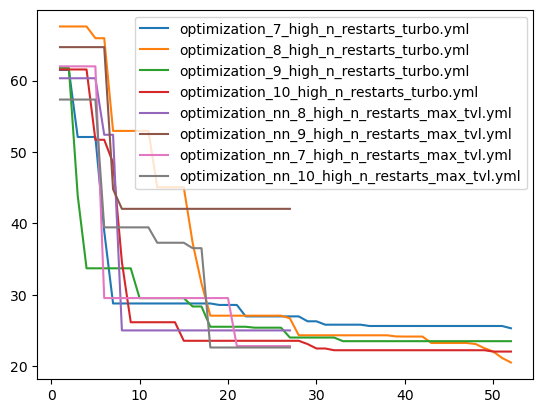

In [3]:
import matplotlib.pyplot as plt
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

def add_minimum(df, key):
    min_val = []
    for ii in range(len(df)):
         min_val += [df[key].iloc[:ii+1].min()]
    df[key + "_min"] = min_val
    return df


fig,ax = plt.subplots()
for i, ele in enumerate(dfs):
    ele.index = ele.index.astype("int")
    ele = ele.sort_index()
    ele_with_min = add_minimum(ele, "total_rms_size")

    ele_with_min.plot(y=["total_rms_size_min"],ax=ax,label=[f_names[i]])

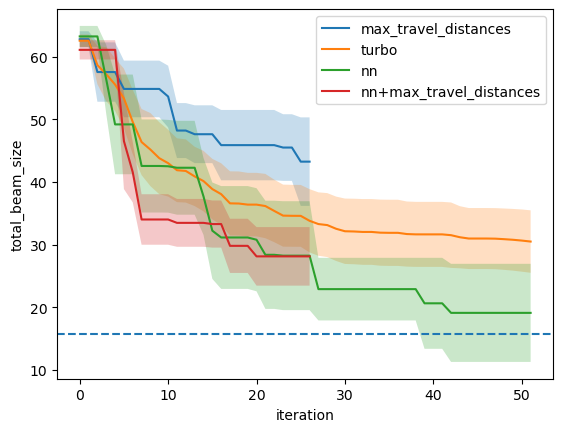

In [6]:
import numpy as np
def get_mean_performance(f_names):
    dfs = []
    for name in f_names:
        with open(folder + name, "r") as file:
            f = yaml.safe_load(file)
            df = pd.DataFrame(f["data"])
            df.index = df.index.astype("int")
            df = df.sort_index()

            # add minimum
            df = add_minimum(df, "total_rms_size")

            dfs += [df]

    _performance = pd.concat([ele["total_rms_size_min"] for ele in dfs], axis=1)
    performance = pd.concat([
        _performance.mean(axis=1),
        _performance.std(axis=1) / np.sqrt(
            len(f_names) - _performance.isna().sum(axis=1)
        )
    ],axis=1, names=["mean","std"])
    performance.columns = ["mean","std"]
    return performance

nn_performance = get_mean_performance([
    "optimization_nn_3_high_n_restarts.yml",
    "optimization_nn_4_high_n_restarts.yml",
    "optimization_nn_5_high_n_restarts.yml",
    "optimization_nn_6_high_n_restarts.yml",
    "optimization_nn_7_high_n_restarts.yml",
]).to_numpy()

nn_max_travel_performance = get_mean_performance([
    "optimization_nn_8_high_n_restarts_max_tvl.yml",
    "optimization_nn_9_high_n_restarts_max_tvl.yml",
    "optimization_nn_7_high_n_restarts_max_tvl.yml",
    "optimization_nn_10_high_n_restarts_max_tvl.yml",
]).to_numpy()

turbo_performance = get_mean_performance([
    "optimization_5_high_n_restarts_turbo.yml",
    "optimization_4_high_n_restarts_turbo.yml",
    "optimization_6_high_n_restarts_turbo.yml",
    "optimization_7_high_n_restarts_turbo.yml",
    "optimization_8_high_n_restarts_turbo.yml",
    "optimization_9_high_n_restarts_turbo.yml",
    "optimization_10_high_n_restarts_turbo.yml",
]).to_numpy()

vanilla_performance = get_mean_performance([
    "optimization_8_high_n_restarts_max_tvl.yml",
    "optimization_6_high_n_restarts_max_tvl.yml",
    "optimization_7_high_n_restarts_max_tvl.yml",
    "optimization_10_high_n_restarts_max_tvl.yml",
]).to_numpy()

fig,ax = plt.subplots()

results = [vanilla_performance, turbo_performance, nn_performance, nn_max_travel_performance]
labels = ["max_travel_distances", "turbo","nn", "nn+max_travel_distances"]
for ele, label in zip(results, labels):
    ax.plot(ele[:,0], label=label)
    ax.fill_between(np.arange(len(ele)),
        ele[:,0] - ele[:,1],
        ele[:,0] + ele[:,1],alpha=0.25
    )

ax.set_xlabel("iteration")
ax.set_ylabel("total_beam_size")
ax.axhline(15.790469, ls="--")
ax.legend()
fig.savefig("awa_nn_prior_results.png", dpi=300)
